In [1]:
# Install BERTopic & required libs safely in Kaggle
!pip install bertopic hdbscan umap-learn sentence-transformers --no-deps
!pip install numpy==1.26.4 scikit-learn==1.5.1 --no-deps


In [2]:
!pip uninstall -y protobuf


Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3


In [3]:
!pip install protobuf==3.20.3 --force-reinstall


  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incomp

In [4]:
import google.protobuf
print(google.protobuf.__version__)


3.20.3


In [5]:
# Cell 1: Imports
import os
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import umap
import hdbscan
import joblib

print("✅ Imports completed")


2025-12-13 14:25:26.014480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765635926.035327     182 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765635926.041708     182 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Imports completed


In [6]:
# 2. Load Reddit and Instagram datasets
import pandas as pd

reddit_fp = "/kaggle/input/reddit/reddit.csv"
insta_fp  = "/kaggle/input/instagram/combined_captions_cleaned.csv"

df_reddit = pd.read_csv(reddit_fp)
df_insta  = pd.read_csv(insta_fp)

print("Reddit rows:", len(df_reddit))
print("Instagram rows:", len(df_insta))
print("Reddit sample:")
print(df_reddit.head(2))
print("Instagram sample:")
print(df_insta.head(2))


Reddit rows: 1000000
Instagram rows: 17100
Reddit sample:
       subreddit                                               body  \
0  gameofthrones  Your submission has been automatically removed...   
1            aww  Dont squeeze her with you massive hand, you me...   

   controversiality  score  
0                 0      1  
1                 0     19  
Instagram sample:
   Sr No  Image File                                            Caption  \
0    2.0  img/insta2                                               bye    
1    3.0  img/insta3  Ok, a few more... sorry I just had so much fun...   

   20516  img2/insta20516  wHaT dAy Is It Even #stayhomeclub  
0    NaN              NaN                                NaN  
1    NaN              NaN                                NaN  


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [7]:
# 3. Vectorized text cleaning function
def clean_text_vectorized(df, text_column):
    """
    Clean text data in a DataFrame column:
    - Lowercase
    - Remove URLs
    - Remove non-alphanumeric characters except #
    - Remove extra whitespace
    """
    df_clean = df.copy()
    df_clean[text_column] = df_clean[text_column].fillna('').astype(str).str.lower()
    df_clean[text_column] = df_clean[text_column].str.replace(r"http\S+|www\S+", "", regex=True)
    df_clean[text_column] = df_clean[text_column].str.replace(r"[^a-zA-Z0-9\s#]", "", regex=True)
    df_clean[text_column] = df_clean[text_column].str.replace(r"\s+", " ", regex=True).str.strip()
    return df_clean


In [8]:
# 4. Load datasets and clean text

# File paths
reddit_fp = "/kaggle/input/reddit/reddit.csv"
insta_fp  = "/kaggle/input/instagram/combined_captions_cleaned.csv"

# Load CSVs
df_reddit = pd.read_csv(reddit_fp)
df_insta  = pd.read_csv(insta_fp)

# Reddit text column
text_col_reddit = 'body' if 'body' in df_reddit.columns else 'text'
df_reddit = df_reddit[[text_col_reddit]].copy()
df_reddit['source'] = 'reddit'
df_reddit.rename(columns={text_col_reddit:'text'}, inplace=True)
df_reddit = clean_text_vectorized(df_reddit, 'text')
df_reddit.rename(columns={'text':'clean_text'}, inplace=True)

# Instagram text column
text_col_insta = 'Caption' if 'Caption' in df_insta.columns else 'text'
df_insta = df_insta[[text_col_insta]].copy()
df_insta['source'] = 'instagram'
df_insta.rename(columns={text_col_insta:'text'}, inplace=True)
df_insta = clean_text_vectorized(df_insta, 'text')
df_insta.rename(columns={'text':'clean_text'}, inplace=True)

# Combine datasets
df_combined = pd.concat([df_reddit, df_insta], ignore_index=True)
print("Combined dataset shape:", df_combined.shape)
df_combined.head(3)


Combined dataset shape: (1017100, 2)


,clean_text,source
0,your submission has been automatically removed...,reddit
1,dont squeeze her with you massive hand you mea...,reddit
2,its pretty well known and it was a paid produc...,reddit


In [9]:
# 5. Optional: quick cleaning filter (drop very short / empty documents)
df_combined['clean_text'] = df_combined['clean_text'].astype(str)
df_combined = df_combined[df_combined['clean_text'].str.strip() != '']
df_combined = df_combined[df_combined['clean_text'].str.len() >= 10].reset_index(drop=True)
print("After filtering short/empty texts:", df_combined.shape)
df_combined.head(3)


After filtering short/empty texts: (989103, 2)


,clean_text,source
0,your submission has been automatically removed...,reddit
1,dont squeeze her with you massive hand you mea...,reddit
2,its pretty well known and it was a paid produc...,reddit


In [10]:
# 7. Sample for speed (adjusted to safe maximum for Kaggle)
sample_size = 50000   # safe upper limit for RAM and time
df_sample = df_combined.sample(n=min(sample_size, len(df_combined)), random_state=42).reset_index(drop=True)
print("BERTopic will run on sample:", df_sample.shape)


BERTopic will run on sample: (50000, 2)


In [11]:
# 8. Build embeddings model (SentenceTransformers). Choose model that fits memory/time.
from sentence_transformers import SentenceTransformer

embedding_model_name = "all-MiniLM-L6-v2"   # fast & compact
embedding_model = SentenceTransformer(embedding_model_name)

# Compute embeddings (batching)
texts = df_sample['clean_text'].astype(str).tolist()
embeddings = embedding_model.encode(texts, show_progress_bar=True, batch_size=32)
print("Embeddings shape:", np.array(embeddings).shape)


Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Embeddings shape: (50000, 384)


In [12]:
# 9. UMAP (dimensionality reduction before HDBSCAN)
import umap

umap_model = umap.UMAP(
    n_neighbors=15,
    n_components=5,   # small number for clustering stability
    min_dist=0.0,
    metric='cosine',
    random_state=42
)


In [13]:
# 10. HDBSCAN clustering model
import hdbscan

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=30,    # slightly larger to reduce noise
    metric='euclidean',     # run on UMAP reduced space (euclidean is fine)
    cluster_selection_method='eom',
    prediction_data=True
)


In [14]:
# 11. Create BERTopic model (link UMAP and HDBSCAN)
from bertopic import BERTopic

topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    calculate_probabilities=True,
    verbose=True
)


In [15]:
!pip install umap-learn==0.5.3 --no-deps


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
# 12. Fit BERTopic (this returns topic assignments and probabilities)
topics, probs = topic_model.fit_transform(df_sample['clean_text'].tolist(), embeddings)
print("Number of documents clustered:", len(topics))


2025-12-13 14:26:32,408 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-13 14:27:43,121 - BERTopic - Dimensionality - Completed ✓
2025-12-13 14:27:43,125 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-13 14:28:27,720 - BERTopic - Cluster - Completed ✓
2025-12-13 14:28:27,735 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-13 14:28:28,705 - BERTopic - Representation - Completed ✓


Number of documents clustered: 50000


In [17]:
# 13. Topic info, top words and examples
topic_info = topic_model.get_topic_info()
print("Top 20 topics overview:")
print(topic_info.head(20))

# Show top words for the first 10 topics (skip -1 which are outliers)
for topic_id in topic_info['Topic'].unique()[:10]:
    if topic_id == -1:
        continue
    top_words = topic_model.get_topic(topic_id)
    print(f"\nTopic {topic_id} top words:", [word for word, _ in top_words[:10]])


Top 20 topics overview:
    Topic  Count                           Name  \
0      -1  27775               -1_the_to_it_and   
1       0   1080    0_mueller_barr_trump_report   
2       1    788       1_thanos_marvel_thor_cap   
3       2    748  2_opinion_you_youre_unpopular   
4       3    701      3_movie_movies_film_scene   
5       4    613    4_show_episode_season_books   
6       5    544       5_eat_sauce_pizza_cheese   
7       6    512            6_thats_lol_oh_what   
8       7    506      7_wwe_wrestling_vince_aew   
9       8    505          8_qb_year_jones_draft   
10      9    462      9_calls_spy_earnings_puts   
11     10    389     10_he_him_relationship_you   
12     11    377      11_song_music_sound_album   
13     12    342  12_florida_alabama_south_ohio   
14     13    322            13_her_she_shes_you   
15     14    296     14_gun_guns_shootings_mass   
16     15    289     15_day_weeks_hours_minutes   
17     16    288  16_dank_downvote_comment_meme   
18     

In [18]:
# 14. Save topic assignments back to dataframe and save results
df_sample['topic'] = topics
# Take the maximum probability for each document as a summary
df_sample['topic_prob'] = [float(p.max()) if p is not None and len(p) > 0 else 0.0 for p in probs]

# Create folder for BERTopic results
os.makedirs("/kaggle/working/bertopic_results", exist_ok=True)

# Save assignments to CSV
df_sample.to_csv("/kaggle/working/bertopic_results/bertopic_topic_assignments.csv", index=False)
print("✅ Saved topic assignments to /kaggle/working/bertopic_results/bertopic_topic_assignments.csv")


✅ Saved topic assignments to /kaggle/working/bertopic_results/bertopic_topic_assignments.csv


In [19]:
# 15. Save BERTopic model & UMAP/HDBSCAN objects for later reuse
# Save BERTopic model
topic_model.save("/kaggle/working/bertopic_results/bertopic_model")

# Save UMAP and HDBSCAN models separately using joblib
joblib.dump(umap_model, "/kaggle/working/bertopic_results/umap_model.pkl")
joblib.dump(hdbscan_model, "/kaggle/working/bertopic_results/hdbscan_model.pkl")

print("✅ Saved BERTopic model, UMAP model, and HDBSCAN model to /kaggle/working/bertopic_results/")


2025-12-13 14:28:30,205 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


✅ Saved BERTopic model, UMAP model, and HDBSCAN model to /kaggle/working/bertopic_results/


In [20]:
# 16. Visualizations (run in notebook; these render inline)
# Topic overview
fig1 = topic_model.visualize_topics()
fig1.show()

# Barchart of topic frequencies (top 30 topics)
fig2 = topic_model.visualize_barchart(top_n_topics=30)
fig2.show()

# Topic hierarchy
fig3 = topic_model.visualize_hierarchy()
fig3.show()

# If running in a headless environment (like Kaggle), save figures as HTML
fig1.write_html("/kaggle/working/bertopic_results/visualize_topics.html")
fig2.write_html("/kaggle/working/bertopic_results/visualize_barchart.html")
fig3.write_html("/kaggle/working/bertopic_results/visualize_hierarchy.html")

print("✅ Saved interactive visualizations as HTML in /kaggle/working/bertopic_results/")


✅ Saved interactive visualizations as HTML in /kaggle/working/bertopic_results/


In [21]:
# Correct usage with BERTopic >=0.17
refined_topics = topic_model.reduce_outliers(
    documents=df_sample['clean_text'].tolist(),
    topics=df_sample['topic'].tolist(),
    embeddings=embeddings,
    threshold=0.05
)

# Assign back to dataframe
df_sample['topic_refined'] = refined_topics

# Save refined topic assignments
df_sample.to_csv("/kaggle/working/bertopic_results/bertopic_topic_assignments_refined.csv", index=False)
print("✅ Refined outliers and saved refined topic assignments to:")
print("/kaggle/working/bertopic_results/bertopic_topic_assignments_refined.csv")


100%|██████████| 28/28 [00:06<00:00,  4.62it/s]


✅ Refined outliers and saved refined topic assignments to:
/kaggle/working/bertopic_results/bertopic_topic_assignments_refined.csv


In [22]:

def show_top_docs_per_topic(df, topic_col='topic', text_col='clean_text', top_n=5):
    for t in sorted(df[topic_col].unique()):
        if t == -1:  # skip outliers
            continue
        subset = df[df[topic_col] == t].head(top_n)
        print(f"\n--- Topic {t} (n={len(df[df[topic_col] == t])}) ---")
        for i, row in subset.iterrows():
            print("-", row[text_col][:160].replace("\n"," "), "...")
            
# Example usage with original topic assignments
show_top_docs_per_topic(df_sample, topic_col='topic', text_col='clean_text', top_n=5)

# Example usage with refined topic assignments
show_top_docs_per_topic(df_sample, topic_col='topic_refined', text_col='clean_text', top_n=5)



--- Topic 0 (n=1080) ---
- so he can perjure himself a little more before mueller comes in to set the record straight ...
- isnt it ironic that clinton was on the watergate special prosecutorial committee what goes around comes around ...
- we have rapist and blackface democrat politicians and all of a sudden throwing ice cubes is unforgivable ...
- he specifically supported segregating schools the wmds thing was obviously not true and definitely not actionable intel to support a war over the patriot act is ...
- the gop base never checks sources though theyre a very gullible group and even though the full report minus redactions has been out for weeks there are still pe ...

--- Topic 1 (n=788) ---
- i thought he was good as the story with the avengers continued i think age of ultron will be appreciated ny attack motivates tony to create ultron ultron goes r ...
- is no one gonna talk about how he freakin tried to body shield groot when thanos was barraging the damn ground with canno

In [23]:
# 19. Optional: Refine outliers using embeddings (map topic -1 to existing topics)
# Note: BERTopic requires documents and embeddings for reduce_outliers
refined_topics = topic_model.reduce_outliers(
    topics=df_sample['topic'].tolist(),
    documents=df_sample['clean_text'].tolist(),
    embeddings=embeddings,
    threshold=0.05
)

df_sample['topic_refined'] = refined_topics
print("Outliers refined. Example assignments:")
print(df_sample[['clean_text','topic','topic_refined']].head(10))


100%|██████████| 28/28 [00:05<00:00,  4.74it/s]


Outliers refined. Example assignments:
                                          clean_text  topic  topic_refined
0                   well you did vandalise his mower     -1             -1
1                       which weapon r u looking for     22             22
2  asking someone on a date is sexually motivated...     -1             13
3  i thought he was good as the story with the av...      1              1
4                                muda muda muda muda     56             56
5        its i believe this is yours captain america     -1              1
6     holy shit why does it look like a homo erectus     -1             96
7  yeah they can ignore itdownvote all they want ...     -1             50
8                yes do it in klassic survivor tower     -1             69
9  i know you can vomit feces i never considered ...     -1             26


In [24]:
# 20. Topic distribution overview
topic_counts = df_sample['topic_refined'].value_counts().sort_index()
print("\nTopic distribution (after refinement):")
for t, count in topic_counts.items():
    print(f"Topic {t}: {count} documents ({count/len(df_sample)*100:.1f}%)")



Topic distribution (after refinement):
Topic -1: 2425 documents (4.9%)
Topic 0: 1226 documents (2.5%)
Topic 1: 948 documents (1.9%)
Topic 2: 1982 documents (4.0%)
Topic 3: 1070 documents (2.1%)
Topic 4: 1131 documents (2.3%)
Topic 5: 628 documents (1.3%)
Topic 6: 1761 documents (3.5%)
Topic 7: 535 documents (1.1%)
Topic 8: 807 documents (1.6%)
Topic 9: 601 documents (1.2%)
Topic 10: 2333 documents (4.7%)
Topic 11: 543 documents (1.1%)
Topic 12: 565 documents (1.1%)
Topic 13: 982 documents (2.0%)
Topic 14: 439 documents (0.9%)
Topic 15: 805 documents (1.6%)
Topic 16: 442 documents (0.9%)
Topic 17: 393 documents (0.8%)
Topic 18: 462 documents (0.9%)
Topic 19: 393 documents (0.8%)
Topic 20: 522 documents (1.0%)
Topic 21: 390 documents (0.8%)
Topic 22: 414 documents (0.8%)
Topic 23: 310 documents (0.6%)
Topic 24: 416 documents (0.8%)
Topic 25: 324 documents (0.6%)
Topic 26: 295 documents (0.6%)
Topic 27: 378 documents (0.8%)
Topic 28: 332 documents (0.7%)
Topic 29: 285 documents (0.6%)
To

In [25]:
# 21. Top words per topic (using BERTopic's get_topic)
print("\nTop words per topic (after refinement):")
for topic_id in sorted(df_sample['topic_refined'].unique()):
    if topic_id == -1:
        continue
    top_words = topic_model.get_topic(topic_id)
    print(f"Topic {topic_id}: {[w for w, _ in top_words[:10]]}")



Top words per topic (after refinement):
Topic 0: ['mueller', 'barr', 'trump', 'report', 'congress', 'letter', 'he', 'obstruction', 'summary', 'president']
Topic 1: ['thanos', 'marvel', 'thor', 'cap', 'tony', 'timeline', 'avengers', 'stones', 'captain', 'stone']
Topic 2: ['opinion', 'you', 'youre', 'unpopular', 'troll', 'your', 'sarcasm', 'point', 'people', 'are']
Topic 3: ['movie', 'movies', 'film', 'scene', 'films', 'it', 'the', 'was', 'of', 'watch']
Topic 4: ['show', 'episode', 'season', 'books', 'episodes', 'writing', 'series', 'the', 'book', 'they']
Topic 5: ['eat', 'sauce', 'pizza', 'cheese', 'taste', 'food', 'butter', 'hot', 'delicious', 'mcdonalds']
Topic 6: ['thats', 'lol', 'oh', 'what', 'thanks', 'know', 'true', 'yeah', 'right', 'thought']
Topic 7: ['wwe', 'wrestling', 'vince', 'aew', 'he', 'match', 'nxt', 'kofi', 'lesnar', 'hes']
Topic 8: ['qb', 'year', 'jones', 'draft', 'he', 'him', 'team', 'pick', 'round', 'nfl']
Topic 9: ['calls', 'spy', 'earnings', 'puts', 'stock', 'sell

In [26]:
# 22. Topic probability statistics
df_sample['topic_prob_max'] = [float(p.max()) if p is not None and len(p)>0 else 0.0 for p in probs]
print("\nTopic probability statistics:")
print(df_sample['topic_prob_max'].describe())



Topic probability statistics:
count    5.000000e+04
mean     1.826957e-01
std      3.107316e-01
min      8.086460e-07
25%      1.635108e-02
50%      4.018728e-02
75%      1.492114e-01
max      1.000000e+00
Name: topic_prob_max, dtype: float64


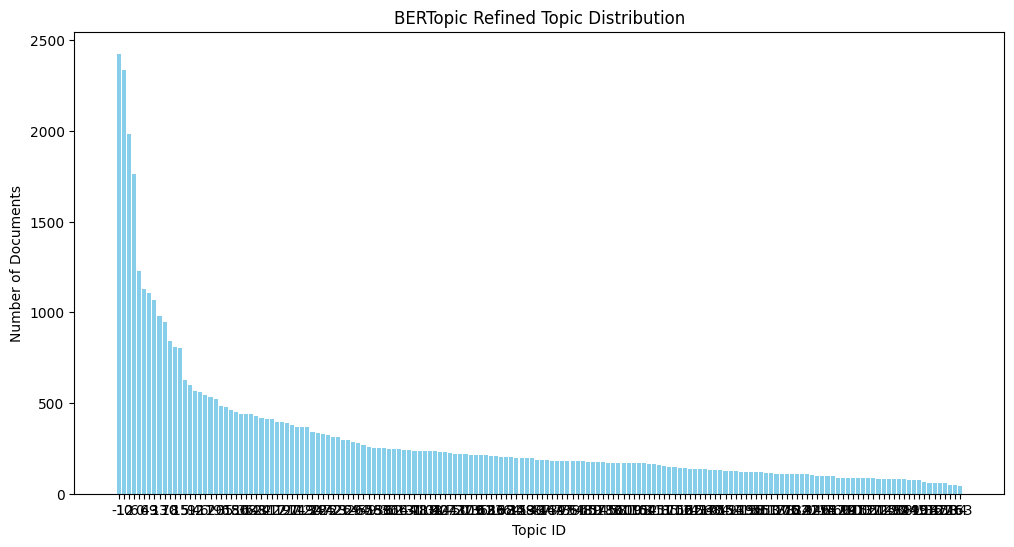

In [27]:
# 25. Quick bar chart of topic frequencies
import matplotlib.pyplot as plt

topic_counts = df_sample['topic_refined'].value_counts()
plt.figure(figsize=(12,6))
plt.bar(topic_counts.index.astype(str), topic_counts.values, color='skyblue')
plt.xlabel("Topic ID")
plt.ylabel("Number of Documents")
plt.title("BERTopic Refined Topic Distribution")
plt.show()


In [28]:
# 27. Save BERTopic model & embeddings for later reuse
topic_model.save("/kaggle/working/bertopic_results/bertopic_model_refined")
joblib.dump(umap_model, "/kaggle/working/bertopic_results/umap_model_refined.pkl")
joblib.dump(hdbscan_model, "/kaggle/working/bertopic_results/hdbscan_model_refined.pkl")
print("\nSaved BERTopic model, UMAP, and HDBSCAN objects for reuse.")


2025-12-13 14:29:08,211 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.



Saved BERTopic model, UMAP, and HDBSCAN objects for reuse.


In [29]:
# 28. Optional: Export topic-word matrix for further analysis
topic_word_matrix = topic_model.get_topics()
import json
with open("/kaggle/working/bertopic_results/topic_word_matrix.json", "w") as f:
    json.dump(topic_word_matrix, f)
print("Saved topic-word matrix JSON.")


Saved topic-word matrix JSON.


In [30]:
# 29. Trend Detection & Topic Labeling for BERTopic
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

print("TREND DETECTION WITH BERTopic (HDBSCAN)")
print("="*60)

# Copy the dataframe with refined topics
df_trend = df_sample.copy()

# --- Helper functions ---
def filter_meaningful_keywords(keywords, texts):
    generic_words = {
        'like', 'just', 'know', 'think', 'people', 'really', 'would', 'could', 
        'should', 'dont', 'cant', 'wont', 'get', 'got', 'see', 'look', 'said',
        'say', 'make', 'made', 'time', 'good', 'great', 'bad', 'better', 'best',
        'right', 'wrong', 'way', 'thing', 'things', 'stuff', 'something', 'anything',
        'maybe', 'probably', 'actually', 'literally', 'basically', 'seriously'
    }
    meaningful = []
    for keyword in keywords:
        if (keyword not in generic_words and len(keyword) > 2 and not keyword.isdigit()):
            count = sum(1 for text in texts if keyword in text.lower())
            if count > len(texts) * 0.1:  # appears in ≥10% of topic
                meaningful.append(keyword)
    return meaningful[:15]

def calculate_engagement(texts):
    if not texts:
        return 0
    avg_length = np.mean([len(text.split()) for text in texts])
    question_count = sum(1 for text in texts if '?' in text)
    exclamation_count = sum(1 for text in texts if '!' in text)
    score = min(10, (avg_length / 15) + (question_count / len(texts) * 3) + (exclamation_count / len(texts) * 2))
    return round(score, 1)

def identify_trend_topic(keywords, texts):
    all_text = ' '.join(texts).lower()
    keyword_str = ' '.join(keywords).lower()
    
    categories = {
        'Politics & Government': ['trump','biden','president','election','government','vote','law','policy','senate','congress'],
        'Entertainment & Movies': ['movie','film','marvel','disney','netflix','actor','director','trailer','scene','cinema','hollywood','oscar'],
        'Gaming & Esports': ['game','gaming','player','playstation','xbox','nintendo','steam','fortnite','minecraft','cod','level','multiplayer','console'],
        'Technology & Apps': ['iphone','android','apple','google','facebook','twitter','instagram','app','update','software','tech','device','computer','phone'],
        'Sports & Events': ['game','team','player','season','win','score','nfl','nba','mlb','soccer','football','basketball','baseball','championship','tournament'],
        'Social Issues': ['climate','environment','health','education','justice','rights','equality','protest','movement','change','society','community','future'],
        'Personal Stories': ['experience','story','life','family','friend','relationship','work','job','school','home','parent','child','love'],
        'Pop Culture': ['celebrity','famous','star','music','artist','album','song','youtube','tiktok','influencer','viral','trending','meme']
    }
    
    scores = {}
    for category, markers in categories.items():
        score = sum(1 for marker in markers if marker in keyword_str or marker in all_text)
        scores[category] = score
        
    best_category = max(scores, key=scores.get)
    if scores[best_category] < 2:
        return f"Discussion about {', '.join(keywords[:2])}"
    return best_category


TREND DETECTION WITH BERTopic (HDBSCAN)


In [31]:
# 30. Extract trends per topic
trends = []

for topic_id in sorted(df_trend['topic_refined'].unique()):
    cluster_texts = df_trend[df_trend['topic_refined']==topic_id]['clean_text'].tolist()
    if len(cluster_texts) < 5:
        continue  # skip very small topics

    all_words = ' '.join(cluster_texts).lower()
    words = re.findall(r'\b\w+\b', all_words)
    word_counts = Counter(words)
    
    top_keywords = [word for word, _ in word_counts.most_common(15)]
    meaningful_keywords = filter_meaningful_keywords(top_keywords, cluster_texts)
    
    if not meaningful_keywords:
        continue
    
    trends.append({
        'topic_id': topic_id,
        'topic_label': identify_trend_topic(meaningful_keywords, cluster_texts),
        'size': len(cluster_texts),
        'percentage': len(cluster_texts) / len(df_trend) * 100,
        'keywords': meaningful_keywords[:8],
        'sample_posts': cluster_texts[:3],
        'engagement_score': calculate_engagement(cluster_texts)
    })

# Sort by topic size
trends = sorted(trends, key=lambda x: x['size'], reverse=True)


In [32]:
# 31. Display detected trends
print(f"\nTRENDS FOUND ({len(trends)} total):")
for i, trend in enumerate(trends, 1):
    print(f"\n{i}. {trend['topic_label']}")
    print(f"   Volume: {trend['size']} posts ({trend['percentage']:.1f}%)")
    print(f"   Keywords: {', '.join(trend['keywords'][:5])}")
    print(f"   Engagement Score: {trend['engagement_score']}/10")
    print("   Sample posts:")
    for j, post in enumerate(trend['sample_posts'],1):
        preview = post[:120]+"..." if len(post)>120 else post
        print(f"      {j}. {preview}")



TRENDS FOUND (166 total):

1. Personal Stories
   Volume: 2425 posts (4.9%)
   Keywords: the, you
   Engagement Score: 0.4/10
   Sample posts:
      1. well you did vandalise his mower
      2. fornite isnt an fps
      3. its not poison its an acid

2. Personal Stories
   Volume: 2333 posts (4.7%)
   Keywords: the, you, and, that, him
   Engagement Score: 3.1/10
   Sample posts:
      1. hes got a point it sounds a lot like furry talk
      2. imo bernard hill and brad dourif stand out as the two best actors in the trilogy honorable mention goes to andy serkis a...
      3. 34 bullshit he was there when saigon fell

3. Personal Stories
   Volume: 1982 posts (4.0%)
   Keywords: the, you, and, that, are
   Engagement Score: 2.0/10
   Sample posts:
      1. gtevery single word is a synonym you have stated the obvious to the point you havent even presented an argument so you b...
      2. can we please have more of this billboards signs things that actually draw peoples attention newspap

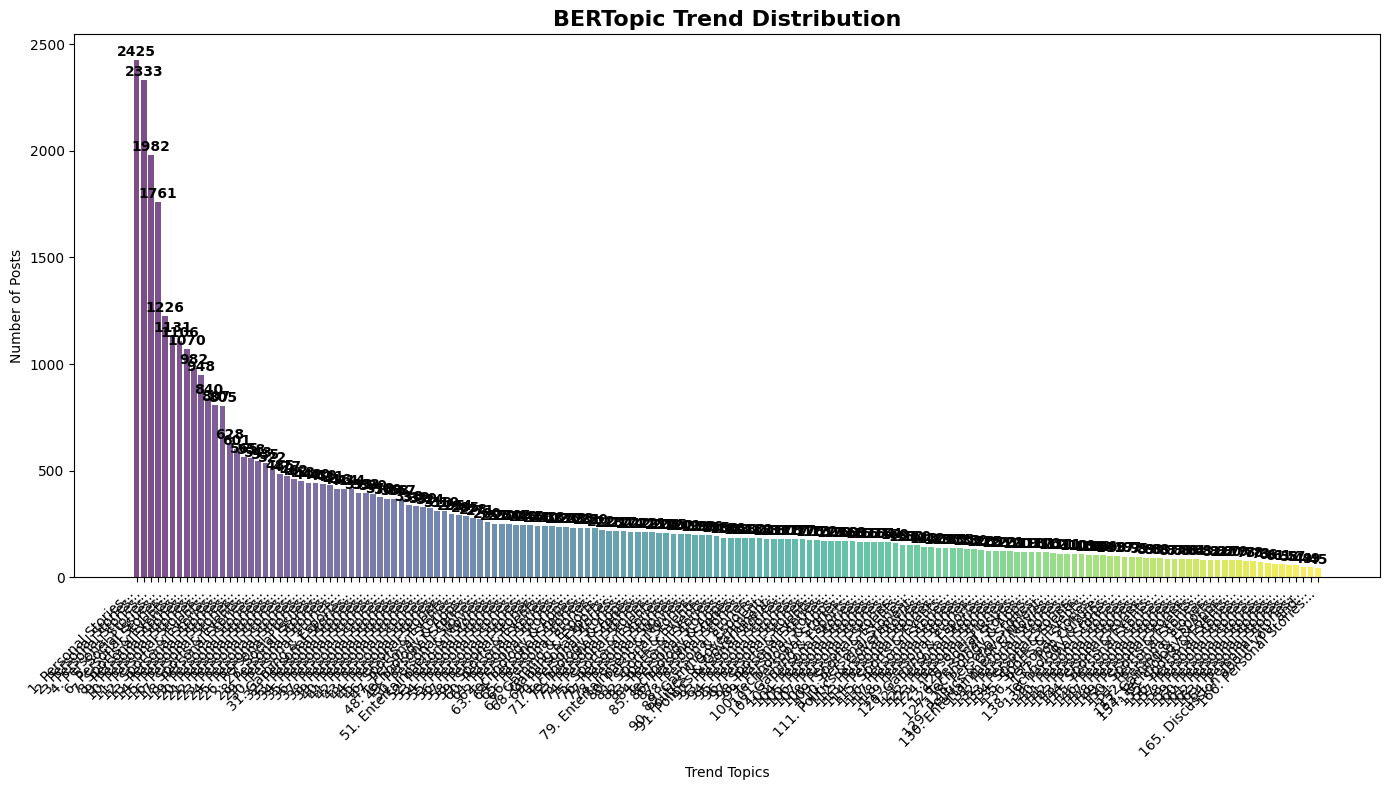

In [33]:
# 32. Visualization of trend distribution
plt.figure(figsize=(14, 8))
trend_labels = [f"{i+1}. {t['topic_label'][:25]}..." for i,t in enumerate(trends)]
trend_sizes = [t['size'] for t in trends]
colors = plt.cm.viridis(np.linspace(0,1,len(trends)))
bars = plt.bar(trend_labels, trend_sizes, color=colors, alpha=0.7)

plt.title("BERTopic Trend Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Trend Topics")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45, ha='right')

# Add counts on bars
for bar, size in zip(bars, trend_sizes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+5, f'{size}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [34]:
# 33. Save trend analysis to CSV
df_trends = pd.DataFrame(trends)
df_trends.to_csv("/kaggle/working/bertopic_results/bertopic_trends_labeled.csv", index=False)
print("Saved BERTopic trend analysis to CSV: bertopic_trends_labeled.csv")


Saved BERTopic trend analysis to CSV: bertopic_trends_labeled.csv


In [35]:
# 34. Evaluate clustering metrics for BERTopic
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

# Get topic assignments and embeddings
topic_labels = df_sample['topic_refined'].values  # or 'topic' if you didn't refine
valid_idx = topic_labels != -1  # exclude outliers (-1)
labels = topic_labels[valid_idx]
embeddings_valid = np.array(embeddings)[valid_idx]  # corresponding embeddings

# Silhouette Score
if len(np.unique(labels)) > 1:
    sil_score = silhouette_score(embeddings_valid, labels)
else:
    sil_score = np.nan  # can't compute for 1 cluster

# Davies-Bouldin Index (lower is better)
dbi = davies_bouldin_score(embeddings_valid, labels) if len(np.unique(labels)) > 1 else np.nan

# Calinski-Harabasz Index (higher is better)
chi = calinski_harabasz_score(embeddings_valid, labels) if len(np.unique(labels)) > 1 else np.nan

print("\n=== BERTopic Clustering Metrics ===")
print(f"Number of topics (excluding outliers): {len(np.unique(labels))}")
print(f"Silhouette Score       : {sil_score:.4f}")
print(f"Davies-Bouldin Index   : {dbi:.4f}")
print(f"Calinski-Harabasz Index: {chi:.2f}")



=== BERTopic Clustering Metrics ===
Number of topics (excluding outliers): 165
Silhouette Score       : -0.0043
Davies-Bouldin Index   : 5.2239
Calinski-Harabasz Index: 48.75


In [37]:
from hdbscan import HDBSCAN
import numpy as np

# Use a subset for fast evaluation (optional)
sample_size = 5000
if embeddings_reduced.shape[0] > sample_size:
    idx = np.random.choice(embeddings_reduced.shape[0], sample_size, replace=False)
    embeddings_eval = embeddings_reduced[idx]
else:
    embeddings_eval = embeddings_reduced

# Define min_cluster_size values to test
min_cluster_sizes = [5, 10, 15]

# Store results
results = []

for size in min_cluster_sizes:
    print(f"\nEvaluating metric='euclidean', min_cluster_size={size} ...")
    
    hdb = HDBSCAN(
        min_cluster_size=size,
        metric='euclidean',
        cluster_selection_method='eom'
    )
    
    labels = hdb.fit_predict(embeddings_eval)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_outliers = list(labels).count(-1)
    
    print(f"Clusters found: {n_clusters}, Outliers: {n_outliers}")
    
    results.append({
        'min_cluster_size': size,
        'clusters': n_clusters,
        'outliers': n_outliers
    })

# Optional: summary
print("\n=== Summary ===")
for r in results:
    print(f"min_cluster_size={r['min_cluster_size']}: Clusters={r['clusters']}, Outliers={r['outliers']}")


NameError: name 'embeddings_reduced' is not defined

In [38]:
# Make sure 'topics' comes from BERTopic fit_transform
# Example from earlier:
# topics, probs = topic_model.fit_transform(df_sample['clean_text'].tolist(), embeddings)

# Assign topics to dataframe
df_sample['topic'] = topics  # use the variable that actually stores topic assignments

# Define columns
text_column = 'clean_text'
cluster_column = 'topic'

# Split into train+val and test (85/15)
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(
    df_sample,
    test_size=0.15,
    random_state=42,
    stratify=df_sample[cluster_column]  # maintain topic distribution
)

# Split train+val into train and validation (70/15)
train, val = train_test_split(
    train_val,
    test_size=0.1765,  # 0.1765 * 0.85 ≈ 0.15 of total
    random_state=42,
    stratify=train_val[cluster_column]
)

# Print dataset sizes
print(f"Train: {len(train)}, Validation: {len(val)}, Test: {len(test)}")

# Optional: Check cluster balance
def cluster_balance(data, cluster_col):
    counts = data[cluster_col].value_counts().sort_index()
    print("Cluster sizes:")
    print(counts)
    print("Cluster balance (std dev):", counts.std())
    print()

print("\nTrain set cluster balance:")
cluster_balance(train, cluster_column)
print("Validation set cluster balance:")
cluster_balance(val, cluster_column)
print("Test set cluster balance:")
cluster_balance(test, cluster_column)


Train: 34998, Validation: 7502, Test: 7500

Train set cluster balance:
Cluster sizes:
topic
-1      19442
 0        756
 1        552
 2        524
 3        491
        ...  
 160       22
 161       21
 162       21
 163       21
 164       21
Name: count, Length: 166, dtype: int64
Cluster balance (std dev): 1505.6896240937865

Validation set cluster balance:
Cluster sizes:
topic
-1      4167
 0       162
 1       118
 2       112
 3       105
        ... 
 160       5
 161       5
 162       5
 163       4
 164       4
Name: count, Length: 166, dtype: int64
Cluster balance (std dev): 322.713981924001

Test set cluster balance:
Cluster sizes:
topic
-1      4166
 0       162
 1       118
 2       112
 3       105
        ... 
 160       5
 161       5
 162       5
 163       5
 164       5
Name: count, Length: 166, dtype: int64
Cluster balance (std dev): 322.63564756654927



In [39]:
import pandas as pd

# Function to summarize cluster distribution
def summarize_clusters(data, cluster_col, split_name):
    counts = data[cluster_col].value_counts().sort_index()
    total = len(data)
    summary = pd.DataFrame({
        'Cluster': counts.index,
        f'{split_name}_Count': counts.values,
        f'{split_name}_Pct': (counts.values / total * 100).round(2)
    })
    return summary

# Summarize each split
train_summary = summarize_clusters(train, cluster_column, 'Train')
val_summary = summarize_clusters(val, cluster_column, 'Validation')
test_summary = summarize_clusters(test, cluster_column, 'Test')

# Merge summaries on Cluster
combined_summary = pd.merge(train_summary, val_summary, on='Cluster', how='outer')
combined_summary = pd.merge(combined_summary, test_summary, on='Cluster', how='outer')

# Fill NaNs with 0 for clusters not present in a split
combined_summary = combined_summary.fillna(0)

# Add total row
total_row = {
    'Cluster': 'Total',
    'Train_Count': combined_summary['Train_Count'].sum(),
    'Train_Pct': combined_summary['Train_Pct'].sum(),
    'Validation_Count': combined_summary['Validation_Count'].sum(),
    'Validation_Pct': combined_summary['Validation_Pct'].sum(),
    'Test_Count': combined_summary['Test_Count'].sum(),
    'Test_Pct': combined_summary['Test_Pct'].sum()
}
combined_summary = pd.concat([combined_summary, pd.DataFrame([total_row])], ignore_index=True)

# Display the combined table
display(combined_summary)


,Cluster,Train_Count,Train_Pct,Validation_Count,Validation_Pct,Test_Count,Test_Pct
0,-1,19442,55.55,4167,55.55,4166,55.55
1,0,756,2.16,162,2.16,162,2.16
2,1,552,1.58,118,1.57,118,1.57
3,2,524,1.50,112,1.49,112,1.49
4,3,491,1.40,105,1.40,105,1.40
...,...,...,...,...,...,...,...
162,161,21,0.06,5,0.07,5,0.07
163,162,21,0.06,5,0.07,5,0.07
164,163,21,0.06,4,0.05,5,0.07
165,164,21,0.06,4,0.05,5,0.07


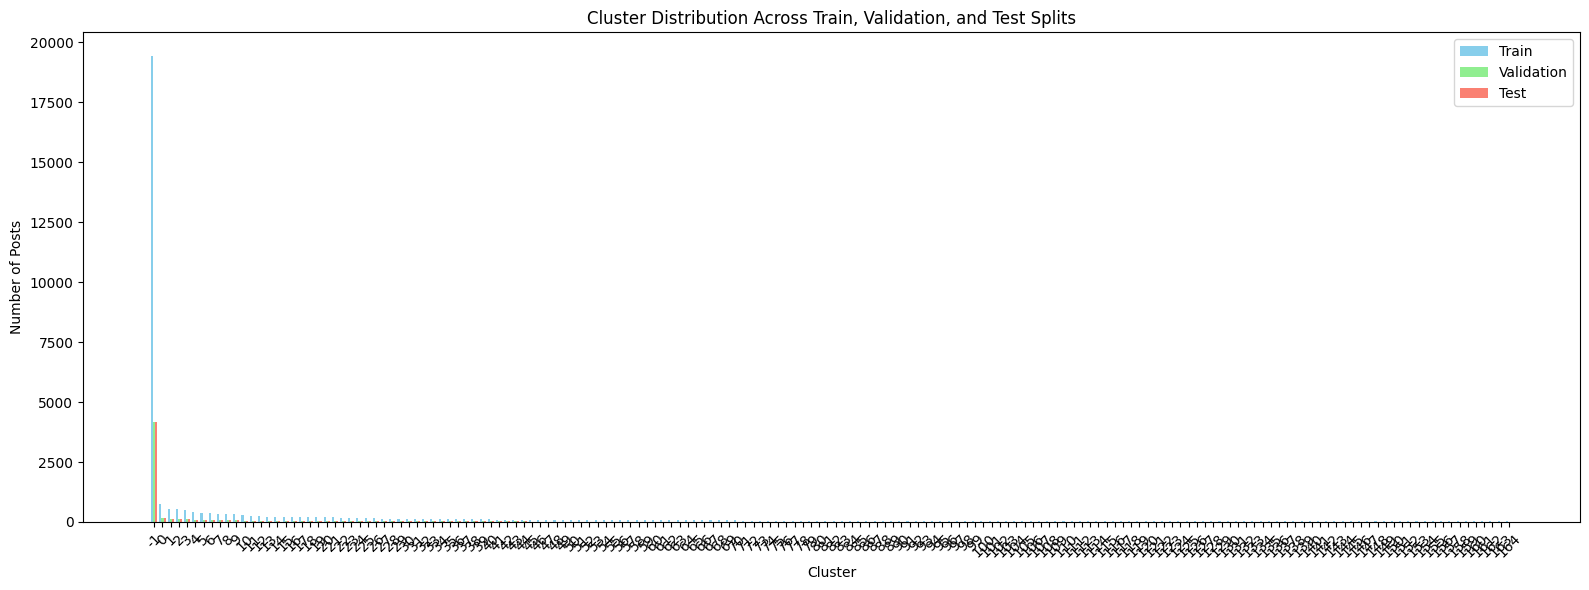

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Exclude 'Total' row for plotting
plot_data = combined_summary[combined_summary['Cluster'] != 'Total'].copy()
clusters = plot_data['Cluster'].astype(str)

# Values
train_vals = plot_data['Train_Count']
val_vals = plot_data['Validation_Count']
test_vals = plot_data['Test_Count']

# Bar positions
x = np.arange(len(clusters))
width = 0.25

# Plot
plt.figure(figsize=(16,6))
plt.bar(x - width, train_vals, width, label='Train', color='skyblue')
plt.bar(x, val_vals, width, label='Validation', color='lightgreen')
plt.bar(x + width, test_vals, width, label='Test', color='salmon')

plt.xlabel('Cluster')
plt.ylabel('Number of Posts')
plt.title('Cluster Distribution Across Train, Validation, and Test Splits')
plt.xticks(x, clusters, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


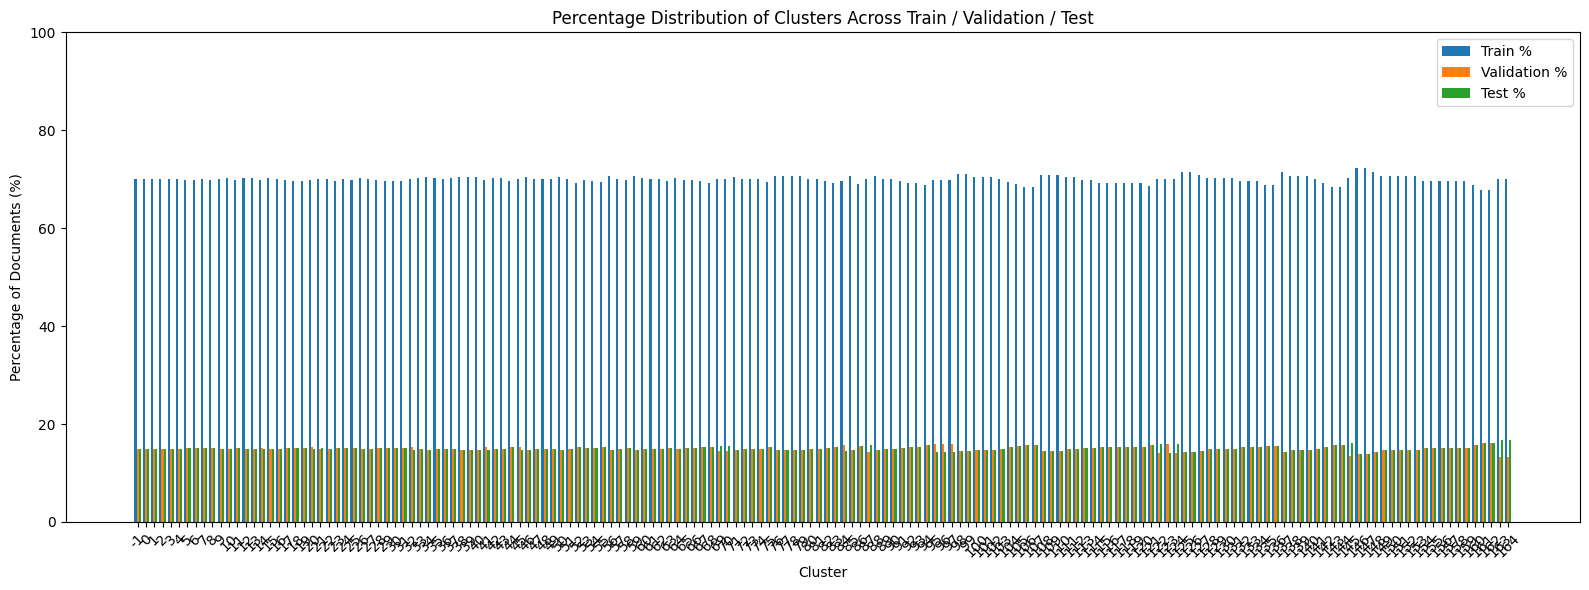

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Exclude Total row
plot_data = combined_summary[combined_summary['Cluster'] != 'Total'].copy()

# Convert cluster labels to string for plotting
clusters = plot_data['Cluster'].astype(str)

# Calculate percentages per cluster
total_per_cluster = (
    plot_data['Train_Count'] +
    plot_data['Validation_Count'] +
    plot_data['Test_Count']
)

train_pct = (plot_data['Train_Count'] / total_per_cluster) * 100
val_pct = (plot_data['Validation_Count'] / total_per_cluster) * 100
test_pct = (plot_data['Test_Count'] / total_per_cluster) * 100

# Bar positions
x = np.arange(len(clusters))
width = 0.25

# Plot
plt.figure(figsize=(16, 6))
plt.bar(x - width, train_pct, width, label='Train %')
plt.bar(x, val_pct, width, label='Validation %')
plt.bar(x + width, test_pct, width, label='Test %')

plt.xlabel('Cluster')
plt.ylabel('Percentage of Documents (%)')
plt.title('Percentage Distribution of Clusters Across Train / Validation / Test')
plt.xticks(x, clusters, rotation=45)
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()


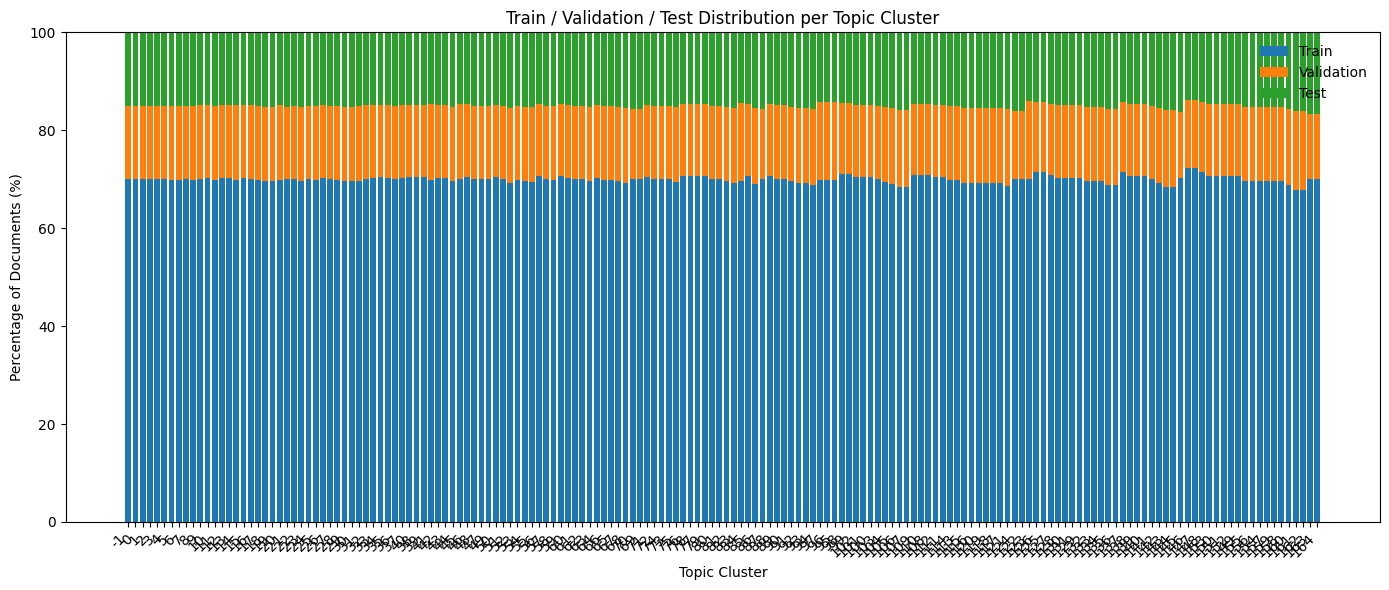

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Exclude total row
plot_data = combined_summary[combined_summary['Cluster'] != 'Total'].copy()

# Sort clusters by total size (descending)
plot_data['Total'] = (
    plot_data['Train_Count'] +
    plot_data['Validation_Count'] +
    plot_data['Test_Count']
)
plot_data = plot_data.sort_values('Total', ascending=False)

clusters = plot_data['Cluster'].astype(str)

# Percentages
train_pct = plot_data['Train_Count'] / plot_data['Total'] * 100
val_pct = plot_data['Validation_Count'] / plot_data['Total'] * 100
test_pct = plot_data['Test_Count'] / plot_data['Total'] * 100

# Plot
plt.figure(figsize=(14, 6))

plt.bar(clusters, train_pct, label='Train')
plt.bar(clusters, val_pct, bottom=train_pct, label='Validation')
plt.bar(clusters, test_pct, bottom=train_pct + val_pct, label='Test')

plt.xlabel('Topic Cluster')
plt.ylabel('Percentage of Documents (%)')
plt.title('Train / Validation / Test Distribution per Topic Cluster')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [43]:
# ======================================
# Improve BERTopic Clustering Metrics
# ======================================

import numpy as np
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.preprocessing import normalize
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from bertopic import BERTopic

# --------------------------------------
# 1. Filter noisy / very short texts
# --------------------------------------
df_filtered = df_sample[df_sample['clean_text'].str.len() > 30].reset_index(drop=True)
docs = df_filtered['clean_text'].tolist()

print("Documents used:", len(docs))

# --------------------------------------
# 2. Normalize embeddings (CRITICAL)
# --------------------------------------
embeddings_norm = normalize(embeddings[:len(docs)])

# --------------------------------------
# 3. UMAP: tighter & cleaner clusters
# --------------------------------------
umap_model = UMAP(
    n_neighbors=15,
    n_components=10,
    min_dist=0.05,
    metric='euclidean',
    random_state=42
)

# --------------------------------------
# 4. HDBSCAN: reduce number of topics
# --------------------------------------
hdbscan_model = HDBSCAN(
    min_cluster_size=15,
    min_samples=10,
    metric='euclidean',
    cluster_selection_method='eom'
)

# --------------------------------------
# 5. BERTopic model
# --------------------------------------
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=False,
    verbose=True
)

# --------------------------------------
# 6. Fit model
# --------------------------------------
topics, _ = topic_model.fit_transform(docs, embeddings_norm)

df_filtered['topic'] = topics

# --------------------------------------
# 7. Metric evaluation (EXCLUDE outliers)
# --------------------------------------
mask = df_filtered['topic'] != -1

embeddings_reduced = umap_model.fit_transform(embeddings_norm)

silhouette = silhouette_score(
    embeddings_reduced[mask],
    df_filtered.loc[mask, 'topic']
)

davies_bouldin = davies_bouldin_score(
    embeddings_reduced[mask],
    df_filtered.loc[mask, 'topic']
)

calinski_harabasz = calinski_harabasz_score(
    embeddings_reduced[mask],
    df_filtered.loc[mask, 'topic']
)

# --------------------------------------
# 8. Results
# --------------------------------------
n_topics = len(set(df_filtered.loc[mask, 'topic']))

print("\n=== Improved BERTopic Clustering Metrics ===")
print(f"Number of topics (excluding outliers): {n_topics}")
print(f"Silhouette Score        : {silhouette:.4f}")
print(f"Davies-Bouldin Index    : {davies_bouldin:.4f}")
print(f"Calinski-Harabasz Index : {calinski_harabasz:.2f}")


2025-12-13 14:50:12,362 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Documents used: 42175


2025-12-13 14:51:08,226 - BERTopic - Dimensionality - Completed ✓
2025-12-13 14:51:08,231 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-13 14:51:12,417 - BERTopic - Cluster - Completed ✓
2025-12-13 14:51:12,428 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-13 14:51:13,567 - BERTopic - Representation - Completed ✓



=== Improved BERTopic Clustering Metrics ===
Number of topics (excluding outliers): 328
Silhouette Score        : 0.5644
Davies-Bouldin Index    : 0.5329
Calinski-Harabasz Index : 13349.22
